In [ ]:
import numpy as np
import pandas as pd
import cv2
import os
import keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from glob import glob

In [ ]:
!mkdir data compressed

In [ ]:
for file in os.listdir('/content/compressed'):
  !unzip {os.path.join("/content/compressed",file)} -d data

Archive:  /content/compressed/CompressMatch10.zip
  inflating: data/match10/video/1_03_01.mp4  
  inflating: data/match10/video/2_04_02.mp4  
  inflating: data/match10/video/1_03_03.mp4  
  inflating: data/match10/video/1_12_16.mp4  
  inflating: data/match10/video/2_14_08.mp4  
  inflating: data/match10/.DS_Store  
  inflating: data/match10/csv/1_03_01_ball.csv  
  inflating: data/match10/csv/2_04_02_ball.csv  
  inflating: data/match10/csv/2_14_08_ball.csv  
  inflating: data/match10/csv/1_12_16_ball.csv  
  inflating: data/match10/csv/1_03_03_ball.csv  
Archive:  /content/compressed/CompressMatch12.zip
  inflating: data/match12/video/1_01_00.mp4  
  inflating: data/match12/video/3_03_03.mp4  
  inflating: data/match12/video/2_05_14.mp4  
  inflating: data/match12/video/1_10_12.mp4  
  inflating: data/match12/video/2_01_01.mp4  
  inflating: data/match12/.DS_Store  
  inflating: data/match12/csv/3_03_03_ball.csv  
  inflating: data/match12/csv/1_01_00_ball.csv  
  inflating: data/mat

In [ ]:
for folder in os.listdir('/content/data'):
  os.makedirs(os.path.join(os.path.join("/content/data",folder),'frame'),exist_ok=True)
  #     print(os.path.join(os.path.join("/Users/apple/Downloads/TrackNetV2/Professional/",directory),'images'))



  for filename in os.listdir(os.path.join(os.path.join("/content/data",folder),'video')):

      os.makedirs(os.path.join(os.path.join("/content/data",folder,"frame"),filename.split('.')[0]),exist_ok=True)

      video = cv2.VideoCapture(os.path.join(os.path.join(os.path.join("/content/data",folder),'video'),filename))
      frame_cnt = 0

      print(os.path.join(os.path.join(os.path.join("/content/data",folder),'video'),filename))
      output_dir = os.path.join(os.path.join("/content/data",folder,"frame"),filename.split('.')[0])

      while True:
          success, frame = video.read()
          if not success:
  #             print("error")
              break
          if frame_cnt>302:
              break
          frame_filename = os.path.join(output_dir, f"{frame_cnt}.jpg")
          cv2.imwrite(frame_filename, frame)
          frame_cnt+=1

      print(frame_cnt)
      print("--------")
  #         print(os.path.join(output_dir, f"frame_{frame_cnt}_{filename.split('.')[0]}.jpg"))

/content/data/match10/video/1_03_03.mp4
303
--------
/content/data/match10/video/1_03_01.mp4
303
--------
/content/data/match10/video/2_04_02.mp4
303
--------
/content/data/match10/video/2_14_08.mp4
303
--------
/content/data/match10/video/1_12_16.mp4
303
--------
/content/data/match11/video/2_05_00.mp4
303
--------
/content/data/match11/video/2_15_04.mp4
303
--------
/content/data/match11/video/1_07_06.mp4
303
--------
/content/data/match11/video/1_03_01.mp4
303
--------
/content/data/match11/video/1_13_13.mp4
303
--------
/content/data/match12/video/3_03_03.mp4
303
--------
/content/data/match12/video/1_10_12.mp4
303
--------
/content/data/match12/video/2_05_14.mp4
303
--------
/content/data/match12/video/2_01_01.mp4
303
--------
/content/data/match12/video/1_01_00.mp4
303
--------


In [ ]:
def genHeatMap(w, h, cx, cy, r, mag):
    if cx <= 0 or cy <= 0:
        return np.zeros((h, w))
    x, y = np.meshgrid(np.linspace(1, w, w), np.linspace(1, h, h))
    heatmap = ((y - (cy + 1))**2) + ((x - (cx + 1))**2)
    heatmap[heatmap <= r**2] = 1
    heatmap[heatmap > r**2] = 0
    return heatmap*mag

In [ ]:
import numpy as np

def get_coordinates_from_heatmap(heatmap):
    """
    Extract (x, y) coordinates from a heatmap.

    Args:
        heatmap: 2D numpy array representing the heatmap.

    Returns:
        (x, y): Tuple of coordinates of the highest value in the heatmap.
    """
    # Flatten the heatmap to find the maximum value
    max_idx = np.argmax(heatmap)
    # Convert the flattened index to 2D coordinates
    y, x = np.unravel_index(max_idx, heatmap.shape)
    return x, y


In [ ]:
BATCH_SIZE=1
HEIGHT=288
WIDTH=512
mag = 1
sigma = 1

main_dir = '/content/data'
game_list = [ m for m in os.listdir('/content/data')]
# p = os.path.join(main_dir, game_list[0], 'frame', '3_15_08', '1.jpg')
# a = tf.keras.preprocessing.image.img_to_array(tf.keras.preprocessing.image.load_img(p))
ratio = 2.0
# dataDir = 'npy'

# if os.path.exists(dataDir):
#     shutil.rmtree(dataDir)
for dir in os.listdir('/content/data'):
  os.makedirs(os.path.join("/content/data",dir,"npy"),exist_ok=True)


In [ ]:
for game in game_list:
    count = 1
    all_path = glob(os.path.join(main_dir,game, 'frame', '*'))
    train_path = all_path[:int(len(all_path)*1)]

    for i in range(len(train_path)):
        train_path[i] = train_path[i][len(os.path.join(main_dir, game, 'frame')) + 1:]

    for p in train_path:
        labelPath = os.path.join(main_dir,game, 'csv', p + '_ball.csv')
        data = pd.read_csv(labelPath)

        no = data['Frame'].values
        v = data['Visibility'].values
        x = data['X'].values
        y = data['Y'].values

        num = no.shape[0]
        r = os.path.join(main_dir, game, 'frame', p)
        x_data_tmp = []
        y_data_tmp = []

        if num<303:
           rang= num-2
        else:
          rang= 303-2

        for i in range(rang):

            unit = []
            for j in range(3):

                target = str(i+j)+'.jpg'
                # print(target)

                png_path = os.path.join(r, target)
                a = load_img(png_path)

                # plt.figure()
                # plt.imshow(a)
                # plt.title(target)

                a = np.asarray(a.resize(size=(WIDTH,HEIGHT)))
                a = a.reshape(288,512,3)
                unit.append(a)

                del a
            unit = np.concatenate(unit,axis=-1)
            x_data_tmp.append(unit)
            del unit

            unit = []
            for j in range(3):
                idx = i+j
                if v[idx] == 0:
                    unit.append(genHeatMap(WIDTH, HEIGHT, -1, -1, sigma, mag))
                else:
                    # print(idx,x[idx],y[idx])
                    scale_x = 512 / 1280
                    scale_y = 288 / 720
                    new_x = int(x[idx] * scale_x)
                    new_y = int(y[idx] * scale_y)
                    # print(idx,new_x,new_y)
                    unit.append(genHeatMap(WIDTH, HEIGHT, int(new_x), int(new_y), sigma, mag))

                    # plt.figure()
                    # plt.imshow(unit[j])
                    # plt.title(i+j)

            unit = np.asarray(unit).reshape(3,288,512,1)
            unit = np.concatenate(unit,axis=-1)
            # print(unit.shape)
            # unit = np.concatenate(unit,axis=-1)
            y_data_tmp.append(unit)
            del unit

            # break


        x_data_tmp2 = np.asarray(x_data_tmp)
        del x_data_tmp
        x_data = x_data_tmp2.astype('float32')
        del x_data_tmp2
        x_data=(x_data/255)

        # print(x_data.shape)
        # x_data = x_data.reshape(x_data.shape[0],x_data.shape[2],x_data.shape[3],x_data.shape[1]*x_data.shape[4])
        # print(x_data.shape)
        # x_data = np.squeeze(x_data,axis=1)

        y_data=np.asarray(y_data_tmp)
        # print(y_data.shape)
        # y_data = np.squeeze(y_data,axis=1)

        # y_data = np.expand_dims(y_data,axis=3)
        # y_data = y_data.reshape(y_data.shape[0],y_data.shape[2],y_data.shape[3],y_data.shape[1])

        del y_data_tmp

        # break

        np.save(os.path.join(main_dir,game,"npy", 'x_data_' + str(count) + '.npy'), x_data)
        np.save(os.path.join(main_dir,game,"npy", 'y_data_' + str(count) + '.npy'), y_data)
        print('============================')
        print(count)
        print(game, p)
        print(x_data.shape)
        print(y_data.shape)
        print('============================')
        del x_data
        del y_data
        count += 1

        # break


1
match10 2_14_08
(301, 288, 512, 9)
(301, 288, 512, 3)
2
match10 1_03_01
(301, 288, 512, 9)
(301, 288, 512, 3)
3
match10 1_12_16
(301, 288, 512, 9)
(301, 288, 512, 3)
4
match10 1_03_03
(301, 288, 512, 9)
(301, 288, 512, 3)
5
match10 2_04_02
(301, 288, 512, 9)
(301, 288, 512, 3)
1
match11 2_15_04
(301, 288, 512, 9)
(301, 288, 512, 3)
2
match11 1_13_13
(301, 288, 512, 9)
(301, 288, 512, 3)
3
match11 1_03_01
(301, 288, 512, 9)
(301, 288, 512, 3)
4
match11 2_05_00
(301, 288, 512, 9)
(301, 288, 512, 3)
5
match11 1_07_06
(301, 288, 512, 9)
(301, 288, 512, 3)
1
match12 1_01_00
(301, 288, 512, 9)
(301, 288, 512, 3)
2
match12 2_05_14
(301, 288, 512, 9)
(301, 288, 512, 3)
3
match12 2_01_01
(301, 288, 512, 9)
(301, 288, 512, 3)
4
match12 3_03_03
(301, 288, 512, 9)
(301, 288, 512, 3)
5
match12 1_10_12
(301, 288, 512, 9)
(301, 288, 512, 3)


In [ ]:
get_coordinates_from_heatmap(y_data[0,:,:,0])

(422, 60)

In [ ]:
z=y_data.reshape(3,288,512,1)


(3, 288, 512, 1)

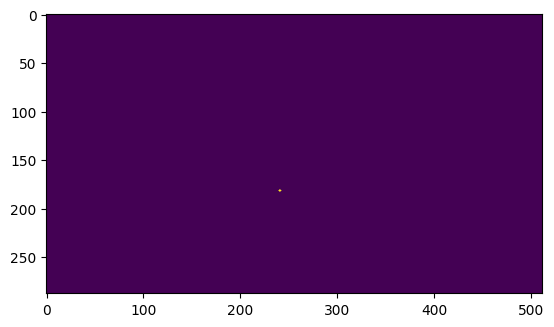

In [ ]:
plt.imshow(y_data[0,:,:,1])

In [ ]:
z = np.concatenate(y_data[0],axis=-1)
z.shape

(288, 1536)

In [ ]:
import numpy as np

def extract_xy_from_heatmap(heatmap):
    # Find the indices where the heatmap has non-zero values
    y_indices, x_indices = np.where(heatmap > 0)

    # Since the heatmap is generated using meshgrid, the indices correspond to the x and y values
    # Note: The x and y values are 1-based in the genHeatMap function
    x_values = x_indices + 1
    y_values = y_indices + 1

    return x_values, y_values

w, h = 512, 288
cx, cy = 50, 50
r = 2
mag = 1

heatmap = genHeatMap(w, h, cx, cy, r, mag)
x_values, y_values = extract_xy_from_heatmap(heatmap)

print("Extracted x values:", x_values)
print("Extracted y values:", y_values)

Extracted x values: [51 50 51 52 49 50 51 52 53 50 51 52 51]
Extracted y values: [49 50 50 50 51 51 51 51 51 52 52 52 53]


In [ ]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *


def TrackNet( input_height, input_width ): #input_height = 288, input_width = 512

	imgs_input = Input(shape=( input_height,input_width,9)) #input channel --> data_format='channels_first'

	#Layer1
	x = Conv2D(64, (3, 3), kernel_initializer='random_uniform', padding='same' )(imgs_input)
	x = ( Activation('relu'))(x)
	x = ( BatchNormalization())(x)

	#Layer2
	x = Conv2D(64, (3, 3), kernel_initializer='random_uniform', padding='same' )(x)
	x = ( Activation('relu'))(x)
	x2 = ( BatchNormalization())(x)

	#Layer3
	x = MaxPooling2D((2, 2), strides=(2, 2) )(x2)

	#Layer4
	x = Conv2D(128, (3, 3), kernel_initializer='random_uniform', padding='same' )(x)
	x = ( Activation('relu'))(x)
	x = ( BatchNormalization())(x)

	#Layer5
	x = Conv2D(128, (3, 3), kernel_initializer='random_uniform', padding='same' )(x)
	x = ( Activation('relu'))(x)
	x5 = ( BatchNormalization())(x)

	#Layer6
	x = MaxPooling2D((2, 2), strides=(2, 2) )(x5)

	#Layer7
	x = Conv2D(256, (3, 3), kernel_initializer='random_uniform', padding='same' )(x)
	x = ( Activation('relu'))(x)
	x = ( BatchNormalization())(x)

	#Layer8
	x = Conv2D(256, (3, 3), kernel_initializer='random_uniform', padding='same' )(x)
	x = ( Activation('relu'))(x)
	x = ( BatchNormalization())(x)

	#Layer9
	x = Conv2D(256, (3, 3), kernel_initializer='random_uniform', padding='same' )(x)
	x = ( Activation('relu'))(x)
	x9 = ( BatchNormalization())(x)

	#Layer10
	x = MaxPooling2D((2, 2), strides=(2, 2) )(x9)

	#Layer11
	x = ( Conv2D(512, (3, 3), kernel_initializer='random_uniform', padding='same'))(x)
	x = ( Activation('relu'))(x)
	x = ( BatchNormalization())(x)

	#Layer12
	x = ( Conv2D(512, (3, 3), kernel_initializer='random_uniform', padding='same'))(x)
	x = ( Activation('relu'))(x)
	x = ( BatchNormalization())(x)

	#Layer13
	x = ( Conv2D(512, (3, 3), kernel_initializer='random_uniform', padding='same'))(x)
	x = ( Activation('relu'))(x)
	x = ( BatchNormalization())(x)

	#Layer14
	x = UpSampling2D((2,2))(x)
	x = concatenate([x, x9], axis=3)

	#Layer15
	x = ( Conv2D(256, (3, 3), kernel_initializer='random_uniform', padding='same'))(x)
	x = ( Activation('relu'))(x)
	x = ( BatchNormalization())(x)

	#Layer16
	x = ( Conv2D(256, (3, 3), kernel_initializer='random_uniform', padding='same'))(x)
	x = ( Activation('relu'))(x)
	x = ( BatchNormalization())(x)

	#Layer17
	x = ( Conv2D(256, (3, 3), kernel_initializer='random_uniform', padding='same'))(x)
	x = ( Activation('relu'))(x)
	x = ( BatchNormalization())(x)

	#Layer18
	x = UpSampling2D((2,2))(x)
	x = concatenate([x, x5], axis=3)

	#Layer19
	x = ( Conv2D(128 , (3, 3), kernel_initializer='random_uniform', padding='same' ))(x)
	x = ( Activation('relu'))(x)
	x = ( BatchNormalization())(x)

	#Layer20
	x = ( Conv2D(128 , (3, 3), kernel_initializer='random_uniform', padding='same'  ))(x)
	x = ( Activation('relu'))(x)
	x = ( BatchNormalization())(x)

	#Layer21
	x = UpSampling2D( (2,2))(x)
	x = concatenate([x, x2], axis=3)

	#Layer22
	x = ( Conv2D(64 , (3, 3), kernel_initializer='random_uniform', padding='same'   ))(x)
	x = ( Activation('relu'))(x)
	x = ( BatchNormalization())(x)

	#Layer23
	x = ( Conv2D(64 , (3, 3), kernel_initializer='random_uniform', padding='same'  ))(x)
	x = ( Activation('relu'))(x)
	x = ( BatchNormalization())(x)

	#Layer24
	x =  Conv2D( 3 , (1, 1) , kernel_initializer='random_uniform', padding='same' )(x)
	x = ( Activation('sigmoid'))(x)


	o_shape = Model(imgs_input , x ).output_shape

	print ("layer24 output shape:", o_shape[1],o_shape[2],o_shape[3])
	#Layer24 output shape: (1, 288, 512)

	OutputHeight = o_shape[0]
	OutputWidth = o_shape[1]

	output = x

	model = Model( imgs_input , output)
	#model input unit:3*288*512, output unit:1*288*512
	model.outputWidth = OutputWidth
	model.outputHeight = OutputHeight

	# Show model's details
	#model.summary()

	return model

In [ ]:
model = TrackNet(HEIGHT, WIDTH)
ADADELTA = tf.keras.optimizers.Adadelta(learning_rate=1.0)
model.compile(loss=['binary_crossentropy'], optimizer=ADADELTA, metrics=['accuracy'])

layer24 output shape: 288 512 3


In [ ]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 288, 512, 9)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 288, 512, 64)   │          5,248 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 288, 512, 64)   │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 288, 512, 64)   │            256 │ activation[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 288, 512, 64)   │         36,928 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 288, 512, 64)   │              0 │ conv2d_1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 288, 512, 64)   │            256 │ activation_1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 144, 256, 64)   │              0 │ batch_normalization_1… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 144, 256, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 144, 256, 128)  │              0 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 144, 256, 128)  │            512 │ activation_2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 144, 256, 128)  │        147,584 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 144, 256, 128)  │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 144, 256, 128)  │            512 │ activation_3[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 72, 128, 128)   │              0 │ batch_normalization_3… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 72, 128, 256)   │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_4 (Activat

 Total params: 11,341,827 (43.27 MB)

 Trainable params: 11,334,147 (43.24 MB)

 Non-trainable params: 7,680 (30.00 KB)

In [ ]:
import os
import sys
import getopt
# import piexif
import numpy as np
from glob import glob
# Keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.activations import *
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import tensorflow as tf

import pandas as pd
import cv2
import math
from sklearn.model_selection import train_test_split
# TrackNet
# from TrackNet import TrackNet

BATCH_SIZE=1
HEIGHT=288
WIDTH=512
mag = 1
sigma = 1

# Return the numbers of true positive, true negative, false positive and false negative
def outcome(y_pred, y_true, tol):
	n = y_pred.shape[0]
	i = 0
	TP = TN = FP1 = FP2 = FN = 0
	while i < n:
		for j in range(1):
			if np.amax(y_pred[i][j]) == 0 and np.amax(y_true[i][j]) == 0:
				TN += 1
			elif np.amax(y_pred[i][j]) > 0 and np.amax(y_true[i][j]) == 0:
				FP2 += 1
			elif np.amax(y_pred[i][j]) == 0 and np.amax(y_true[i][j]) > 0:
				FN += 1
			elif np.amax(y_pred[i][j]) > 0 and np.amax(y_true[i][j]) > 0:
				h_pred = y_pred[i][j] * 255
				h_true = y_true[i][j] * 255
				h_pred = h_pred.astype('uint8')
				h_true = h_true.astype('uint8')
				#h_pred
				(cnts, _) = cv2.findContours(h_pred.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
				rects = [cv2.boundingRect(ctr) for ctr in cnts]
				max_area_idx = 0
				max_area = rects[max_area_idx][2] * rects[max_area_idx][3]
				for j in range(len(rects)):
					area = rects[j][2] * rects[j][3]
					if area > max_area:
						max_area_idx = j
						max_area = area
				target = rects[max_area_idx]
				(cx_pred, cy_pred) = (int(target[0] + target[2] / 2), int(target[1] + target[3] / 2))

				#h_true
				(cnts, _) = cv2.findContours(h_true.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
				rects = [cv2.boundingRect(ctr) for ctr in cnts]
				max_area_idx = 0
				max_area = rects[max_area_idx][2] * rects[max_area_idx][3]
				for j in range(len(rects)):
					area = rects[j][2] * rects[j][3]
					if area > max_area:
						max_area_idx = j
						max_area = area
				target = rects[max_area_idx]
				(cx_true, cy_true) = (int(target[0] + target[2] / 2), int(target[1] + target[3] / 2))
				dist = math.sqrt(pow(cx_pred-cx_true, 2)+pow(cy_pred-cy_true, 2))
				if dist > tol:
					FP1 += 1
				else:
					TP += 1
		i += 1
	return (TP, TN, FP1, FP2, FN)

# Return the values of accuracy, precision and recall
def evaluation(y_pred, y_true, tol):
	(TP, TN, FP1, FP2, FN) = outcome(y_pred, y_true, tol)
	try:
		accuracy = (TP + TN) / (TP + TN + FP1 + FP2 + FN)
	except:
		accuracy = 0
	try:
		precision = TP / (TP + FP1 + FP2)
	except:
		precision = 0
	try:
		recall = TP / (TP + FN)
	except:
		recall = 0
	return (accuracy, precision, recall)



In [ ]:
model= load_model('/content/TrackNet_10.keras')

In [ ]:



paramCount = {
	'load_weights': 0,
	'save_weights': 0,
	'dataDir': 0,
	'epochs': 0,
	'tol': 0
}

tol=4
epochs=1

'''
#you can design your own loss function
def custom_loss(y_true, y_pred):
	loss =
	return loss
'''

# Training for the first time
# if paramCount['load_weights'] == 0:
#     model = TrackNet(HEIGHT, WIDTH)
#     ADADELTA = optimizers.Adadelta(learning_rate=1.0)
#     model.compile(loss=['binary_crossentropy'], optimizer=ADADELTA, metrics=['accuracy']) #loss = my_loss ['binary_crossentropy']
# # Retraining
# else:
#     # if you have own loss function
#     # model = load_model(load_weights, custom_objects={'custom_loss':custom_loss})
#     model = load_model(load_weights)

# model = load_model('/content/TrackNet3-360-640.keras')
print('Beginning training......')
for i in range(epochs):
  print('============epoch', i+1, '================')
  for dir in os.listdir('/content/data'):
    r = os.path.abspath(os.path.join(main_dir,dir,"npy"))
    print(r)

    path = glob(os.path.join(r, '*.npy'))
    num = len(path) / 2  # number of annot files
    idx = np.arange(num, dtype='int') + 1
    # print('Beginning training......')
    # for i in range(epochs):
        # print('============epoch', i+1, '================')
    np.random.shuffle(idx)
    for j in idx:
        x_train = np.load(os.path.abspath(os.path.join(main_dir,dir,"npy", 'x_data_' + str(j) + '.npy')))
        y_train = np.load(os.path.abspath(os.path.join(main_dir,dir,"npy", 'y_data_' + str(j) + '.npy')))

    #         x_train = x_train.reshape(x_train.shape[0],x_train.shape[2],x_train.shape[3],x_train.shape[1])
    #         y_train = y_train.reshape(y_train.shape[0],y_train.shape[2],y_train.shape[3],y_train.shape[1])

        model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=1)
        del x_train
        del y_train

        # Save intermediate weights during training & Show the outcome of training data so long
    if (i+1) % 3 == 0:   # every 3 epochs
            # model.save(save_weights + '_' + str(i + 1))
        TP = TN = FP1 = FP2 = FN = 0
        for j in idx:
                # load .npy file
            x_train = np.load(os.path.abspath(os.path.join(main_dir,dir,"npy", 'x_data_' + str(j) + '.npy')))
            y_train = np.load(os.path.abspath(os.path.join(main_dir,dir,"npy", 'y_data_' + str(j) + '.npy')))

    #             x_train = x_train.reshape(x_train.shape[0],x_train.shape[2],x_train.shape[3],x_train.shape[1])
    #             y_train = y_train.reshape(y_train.shape[0],y_train.shape[2],y_train.shape[3],y_train.shape[1])

            y_pred = model.predict(x_train, batch_size=BATCH_SIZE)
            y_pred = y_pred > 0.5
            y_pred = y_pred.astype('float32')
            (tp, tn, fp1, fp2, fn) = outcome(y_pred, y_train, tol)
            TP += tp
            TN += tn
            FP1 += fp1
            FP2 += fp2
            FN += fn
            del x_train
            del y_train
            del y_pred
        print("Outcome of training data of epoch " + str(i+1) + ":")
        print("Number of true positive:", TP)
        print("Number of true negative:", TN)
        print("Number of false positive FP1:", FP1)
        print("Number of false positive FP2:", FP2)
        print("Number of false negative:", FN)

# print('Saving weights......')
# model.save(save_weights)
# print('Done......')

Beginning training......
============epoch 1 ================
/content/data/match10/npy
301/301 ━━━━━━━━━━━━━━━━━━━━ 67s 130ms/step - accuracy: 0.4025 - loss: 1.0112e-04
301/301 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - accuracy: 0.3917 - loss: 9.8604e-05
301/301 ━━━━━━━━━━━━━━━━━━━━ 43s 144ms/step - accuracy: 0.3974 - loss: 1.0018e-04
301/301 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.4021 - loss: 1.2774e-04
301/301 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.3979 - loss: 9.5323e-05
/content/data/match11/npy
301/301 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.3868 - loss: 9.1084e-05
301/301 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.3782 - loss: 8.5478e-05
301/301 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.3731 - loss: 8.7823e-05
301/301 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.3877 - loss: 7.9321e-05
301/301 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/step - accuracy: 0.3731 - loss: 8.2204e-05
/content/data/match12/npy
301/301 ━━━━━━━━━━━━━━━━━━━━ 44s 145ms/s

'/content/data/match3/npy'

In [ ]:
model.save('TrackNet_11.keras')

In [ ]:
x_train = np.load('/content/data/match10/npy/x_data_3.npy')
y_train = np.load('/content/data/match10/npy/y_data_3.npy')

In [ ]:
x_train.shape

(301, 288, 512, 9)

In [ ]:
y_train.shape

(301, 288, 512, 3)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
pred: 299 161
True: 284 192
--------------------------------


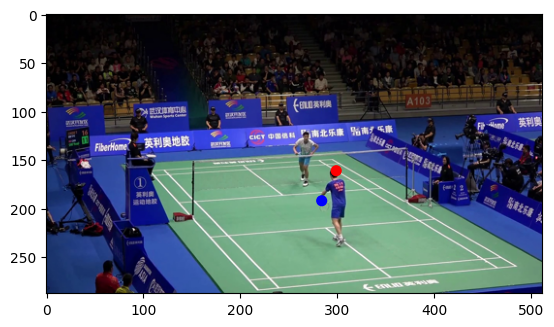

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
pred: 279 148
True: 313 171
--------------------------------


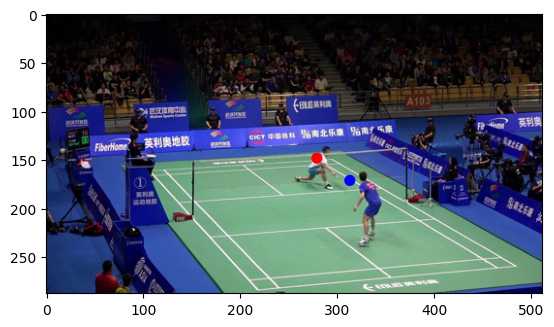

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
pred: 301 163
True: 284 191
--------------------------------


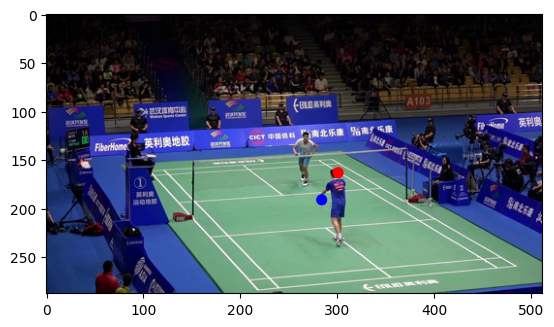

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
pred: 315 229
True: 0 0
--------------------------------


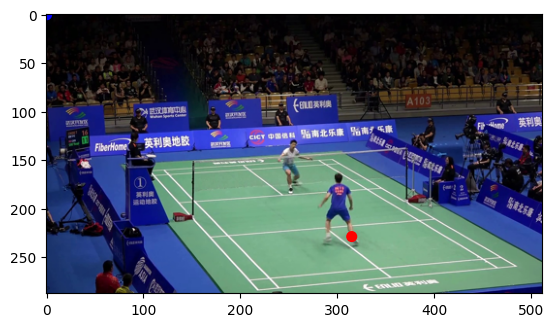

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
pred: 303 228
True: 273 150
--------------------------------


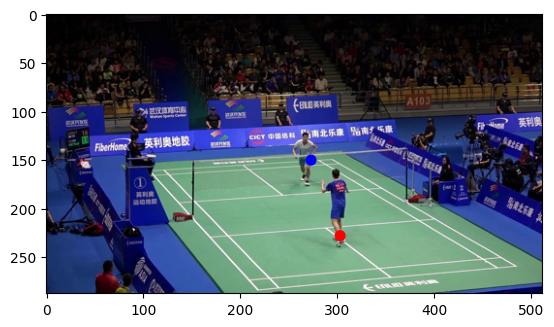

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
pred: 223 129
True: 243 127
--------------------------------


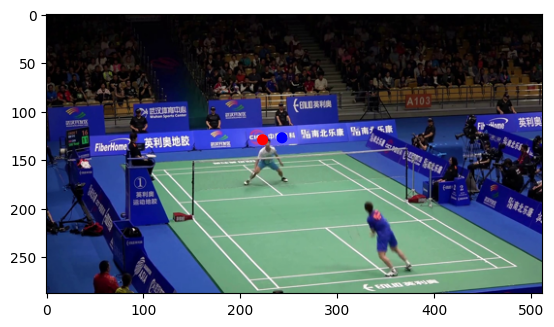

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
pred: 269 140
True: 267 139
--------------------------------


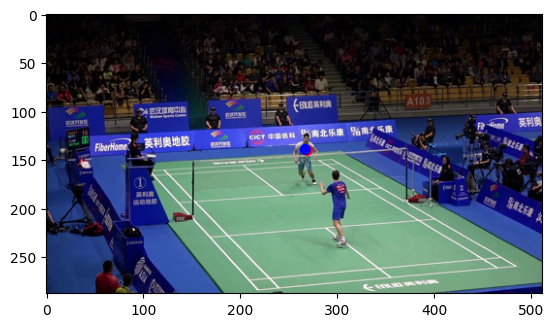

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
pred: 260 142
True: 259 141
--------------------------------


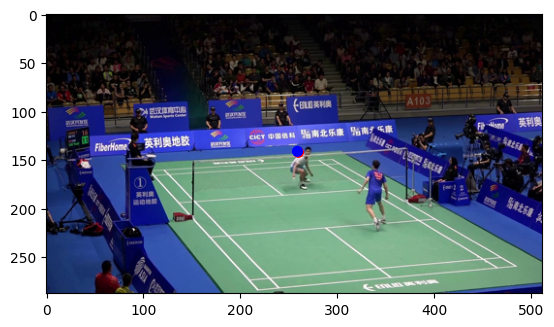

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
pred: 343 175
True: 297 125
--------------------------------


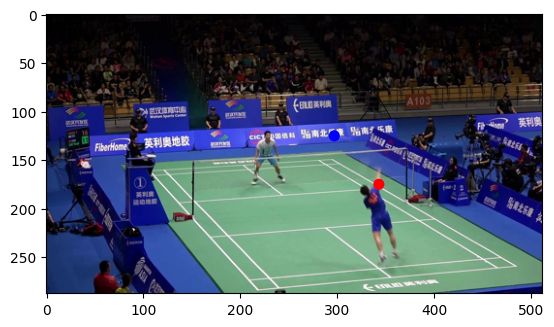

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
pred: 256 45
True: 256 44
--------------------------------


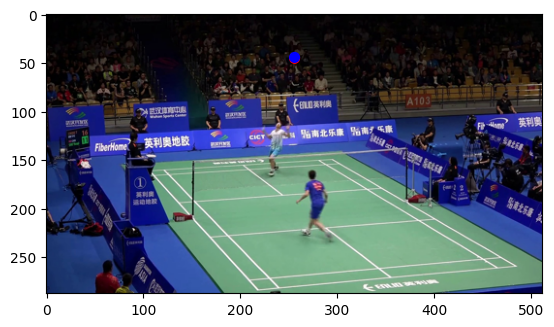

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
for i in np.random.randint(low=0,high=x_train.shape[0]-1,size=10):
  pred = model.predict(np.expand_dims(x_train[i],axis=0))
  px,py = get_coordinates_from_heatmap(pred[0,:,:,0])
  tx,ty = get_coordinates_from_heatmap(y_train[i][:,:,0])
  print("pred:",px,py)
  print("True:",tx,ty)
  print("--------------------------------")
  fig,ax = plt.subplots(1)
  ax.imshow(x_train[i][:,:,0:3])
  circ = Circle((px,py),5,color='red')
  circ2 = Circle((tx,ty),5,color='blue')
  ax.add_patch(circ)
  ax.add_patch(circ2)
  plt.show()


In [ ]:
i=145
for i in np.random.randint(low=0,high=200,size=10):
  pred = model.predict(np.expand_dims(x_train[i],axis=0))
  print("pred:",get_coordinates_from_heatmap(pred[0,:,:,0]))
  print("True:",get_coordinates_from_heatmap(y_train[i][:,:,0]))
  print("--------------------------------")
  print("pred:",get_coordinates_from_heatmap(pred[0,:,:,1]))
  print("True:",get_coordinates_from_heatmap(y_train[i][:,:,1]))
  print("--------------------------------")
  print("pred:",get_coordinates_from_heatmap(pred[0,:,:,2]))
  print("True:",get_coordinates_from_heatmap(y_train[i][:,:,2]))
  print("--------------------------------")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
pred: (194, 108)
True: (202, 86)
--------------------------------
pred: (194, 108)
True: (197, 100)
--------------------------------
pred: (194, 108)
True: (192, 113)
--------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
pred: (271, 126)
True: (0, 0)
--------------------------------
pred: (270, 124)
True: (0, 0)
--------------------------------
pred: (269, 124)
True: (0, 0)
--------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
pred: (176, 116)
True: (176, 115)
--------------------------------
pred: (176, 116)
True: (177, 118)
--------------------------------
pred: (176, 116)
True: (177, 120)
--------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
pred: (228, 71)
True: (218, 43)
--------------------------------
pred: (250, 102)
True: (209, 67)
--------------------------------
pred: (249, 102)
True: (202, 86)
--------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
pred: (170, 118)
True: (1

In [ ]:
img1 = load_img('/content/2.jpg')
img1 = img1.resize(size=(512,288))
img1 = np.asarray(img1)

In [ ]:
unit =[]
unit.append(img1)
unit.append(img1)
unit.append(img1)
img = np.asarray(unit)
img.shape
img = np.concatenate(img,axis=-1)
img = img/255.0
img.shape

(288, 512, 9)

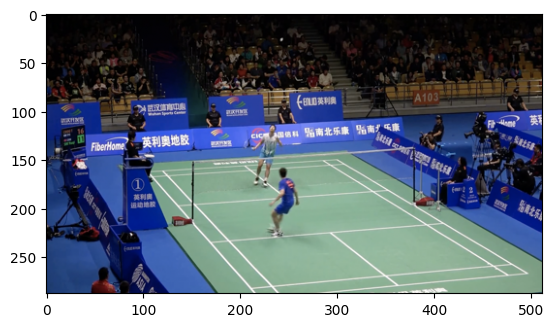

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(img[:,:,0:3])

In [ ]:
pred = model2.predict(np.expand_dims(img,axis=0))
print("pred:",get_coordinates_from_heatmap(pred[0,:,:,0]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
pred: (243, 27)


In [ ]:
import os
import time
directory = '/content/4.mp4'

i=0
j=[]
video = cv2.VideoCapture(directory)
fourcc = cv2.VideoWriter_fourcc(*'mp4v')

frame_width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(video.get(cv2.CAP_PROP_FPS))

out = cv2.VideoWriter('output.mp4', fourcc, fps, (512,288))
while True:
    success, frame = video.read()
    if not success:
        print("error")
        break

    frame = np.asarray(frame)
    frame = cv2.resize(frame,(512,288))
    jframe = frame/255.0

    j.append(jframe)

    if len(j)==3:
        img = np.asarray(j)
        img = np.concatenate(img,axis=-1)

        img = np.expand_dims(img,axis=0)

        # print(img.shape)

        result = model.predict(img)

        x,y = get_coordinates_from_heatmap(result[0,:,:,0])
        print(x,y)
        # break

        j.pop(0)

        frame = cv2.circle(frame, (x,y), radius=5, color=(255,0,0), thickness=2)

        out.write(frame)
    # if len(j)==3:
    #   break

video.release()
out.release()
cv2.destroyAllWindows()



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
510 57
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
510 50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
231 143
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
510 41
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
510 40
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
510 33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
510 29
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
213 74
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
510 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
231 78
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
510 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
476 42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
252 106
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
268 121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
268 121
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
249 101
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
269 119
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
269 118
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
245 102
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
271 110
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
271 110
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
247 111
1